# Load Model

In [1]:
project_dir = '/package_dir/'
pretrained_models = 'pretrained_models/'

model_name = 'VG_relational_grounding/'
trained_path = project_dir+pretrained_models+model_name
import os
os.chdir(project_dir)
import torch
import torch.nn as nn
import models
import numpy as np
import matplotlib.pyplot as plt
import pylab
import math
from collections import OrderedDict

In [2]:
device = 'cuda'

In [3]:
language_model = models.Bert_object(embedding_dim=768).to(device)
image_model = models.VGG16_Attention(embedding_dim=768, pretrained=True, use_position="absolute_learn")
cross_attention_model = models.CrossAttention(num_heads=8, subspace_dim=32, embedding_dim=768, relation_base=115)

In [4]:
transfer_model = models.Trasfer_COCO_Model(image_model, language_model, cross_attention_model)  # TransferCrossModalRetrieval
model_path = trained_path+'best_model.pth'
state_dict = torch.load(model_path, map_location=device)

# create new OrderedDict that does not contain `module.`
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] # remove `module.`
    new_state_dict[name] = v
# load params
transfer_model.load_state_dict(new_state_dict,strict=True)
transfer_model.eval()
transfer_model.to(device)

language_model = transfer_model.language_model
image_model =transfer_model.image_model

In [5]:
# Define maching function (TBD)
def computeMatchmap(I, L):
    assert(I.dim() == 3)
    assert(L.dim() == 2)
    D = I.size(0)
    H = I.size(1)
    W = I.size(2)
    T = L.size(0)
    Ir = I.view(D, -1).t()
    matchmap = torch.mm(Ir, L.t())
    matchmap = matchmap.view(H, W, T)
    return matchmap

def matchmapSim(M):
    assert(M.dim() == 3)
    if M.size()[2]>0:
        M_maxH, _ = M.max(0)
        M_maxHW, _ = M_maxH.max(0)
        return M_maxHW.mean()
    else:
        device = M.device
        return torch.tensor(0).to(device)

# Load data

### from OpenImage dataset

In [6]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import numpy as np
from PIL import Image
class OpenImageDataset(Dataset):
    def __init__(self, datadir, listname):
        text_file = open(datadir+listname, 'r')
        self.data = text_file.readlines()
        text_file.close()
        self.image_base_path = datadir

        self.image_resize_and_crop = transforms.Compose(
            [transforms.Resize(224), transforms.CenterCrop(224), transforms.ToTensor()])

        RGB_mean = [0.485, 0.456, 0.406] # need configuration
        RGB_std = [0.229, 0.224, 0.225] # need configuration
        self.image_normalize = transforms.Normalize(mean=RGB_mean, std=RGB_std)

    def _LoadImage(self, impath):
        img = Image.open(impath).convert('RGB')
        img_original = self.image_resize_and_crop(img)
        img = self.image_normalize(img_original)
        return img_original, img

    def __getitem__(self, index):
        datum = self.data[index][0:-1]
        # caption = os.path.join(self.caption_base_path, datum['caption'])
        imgpath = self.image_base_path+datum+'.jpg'
        img_original, img = self._LoadImage(imgpath)
        return img_original, img
    
    def __len__(self):
        return len(self.data)

In [7]:
datadir = project_dir+'OpenImage/'  # Directory_to_OpenImage
listname = 'image_list_file.txt'
val_loader = torch.utils.data.DataLoader(
    OpenImageDataset(datadir, listname),
    batch_size=1, shuffle=False, num_workers=8, pin_memory=False)

In [8]:
import copy
import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')

searching_image_set = {}
for item, (img_original, img) in enumerate(val_loader):
    img_original_cp = copy.deepcopy(img_original)
    del img_original
    searching_image_set[item] = img_original_cp
    if item % 100 == 0:
        print('Processed: ' + str(item)+ '.')

Processed: 0.
Processed: 100.
Processed: 200.
Processed: 300.
Processed: 400.
Processed: 500.
Processed: 600.
Processed: 700.
Processed: 800.
Processed: 900.
Processed: 1000.
Processed: 1100.
Processed: 1200.
Processed: 1300.
Processed: 1400.
Processed: 1500.
Processed: 1600.
Processed: 1700.
Processed: 1800.
Processed: 1900.
Processed: 2000.
Processed: 2100.
Processed: 2200.
Processed: 2300.
Processed: 2400.
Processed: 2500.
Processed: 2600.
Processed: 2700.
Processed: 2800.
Processed: 2900.
Processed: 3000.
Processed: 3100.
Processed: 3200.
Processed: 3300.
Processed: 3400.
Processed: 3500.
Processed: 3600.
Processed: 3700.
Processed: 3800.
Processed: 3900.
Processed: 4000.
Processed: 4100.
Processed: 4200.
Processed: 4300.
Processed: 4400.
Processed: 4500.
Processed: 4600.
Processed: 4700.
Processed: 4800.
Processed: 4900.
Processed: 5000.
Processed: 5100.
Processed: 5200.
Processed: 5300.
Processed: 5400.
Processed: 5500.
Processed: 5600.
Processed: 5700.
Processed: 5800.
Processed

In [9]:
len(searching_image_set)

41620

# Corss-modal Search

## define queries

In [10]:
from transformers import BertTokenizer, BertModel, BertForMaskedLM, BertConfig
seed_model = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [11]:
def get_output_from_language_stream(language_input):
    input_mask = np.ones((len(language_input),1))
    input_mask = torch.from_numpy(input_mask)
    input_mask = input_mask.type('torch.LongTensor')

    sequence_max_object = 10

    object_input_all = torch.zeros(len(language_input), sequence_max_object).type('torch.LongTensor')
    segments_tensors_all = torch.zeros(len(language_input), sequence_max_object).type('torch.LongTensor')
    input_token_mask_all = torch.zeros(len(language_input), sequence_max_object).type('torch.LongTensor')

    for i in range(len(language_input)):
        tokens = tokenizer.tokenize(language_input[i])
        token_id = tokenizer.convert_tokens_to_ids(tokens)
        tokens_tensor = torch.tensor([101] + token_id + [102]).type('torch.LongTensor') 
        input_token_mask = torch.ones(tokens_tensor.shape[0])
        segments_tensors = torch.ones(tokens_tensor.shape[0])

        p = sequence_max_object - tokens_tensor.shape[0]
        tokens_tensor = np.pad(tokens_tensor, (0, p), 'constant', constant_values=(0, 0))
        input_token_mask = np.pad(input_token_mask, (0, p), 'constant', constant_values=(0, 0))
        segments_tensors = np.pad(segments_tensors, (0, p), 'constant', constant_values=(0, 0))

        tokens_tensor = torch.tensor(tokens_tensor).type('torch.LongTensor')
        input_token_mask = torch.tensor(input_token_mask).type('torch.LongTensor')
        segments_tensors = torch.tensor(segments_tensors).type('torch.LongTensor')

        object_input_all[i,:] = tokens_tensor
        input_token_mask_all[i,:] = input_token_mask
        segments_tensors_all[i,:] = input_token_mask

    object_input_all = object_input_all.to(device)
    segments_tensors_all = segments_tensors_all.to(device)
    input_token_mask_all = input_token_mask_all.to(device)
    input_mask = input_mask.to(device)

    language_output = language_model.language_model(input_ids=object_input_all, token_type_ids=segments_tensors_all, attention_mask=input_token_mask_all).last_hidden_state.squeeze()
    language_output = language_output.to(device)
    return language_output, input_mask

In [12]:
image_resize_and_crop = transforms.Compose([transforms.Resize(224), transforms.CenterCrop(224), transforms.ToTensor()])

RGB_mean = [0.485, 0.456, 0.406] # need configuration
RGB_std = [0.229, 0.224, 0.225] # need configuration
image_normalize = transforms.Normalize(mean=RGB_mean, std=RGB_std)

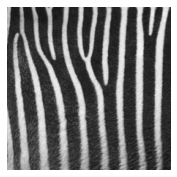

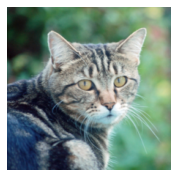

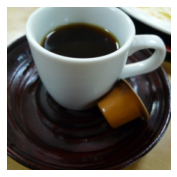

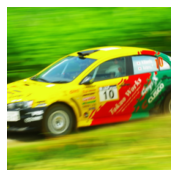

In [14]:
# Define image queries
query_image_dir = datadir + 'cross_modal_search_queries/'
query_image_id = ['zebra','cat','coffee', 'car']
query_image_input = torch.zeros((len(query_image_id),3,224,224))
import matplotlib.pyplot as plt
%matplotlib inline
for i in range(len(query_image_id)):
    impath = query_image_dir+query_image_id[i]+'.png'
    img = Image.open(impath).convert('RGB')
    img_original = image_resize_and_crop(img)
    img = image_normalize(img_original)
    query_image_input[i,:] = img
    fig, ax = plt.subplots(figsize = (3,3))
    ax.axis('off')
    im = ax.imshow(np.transpose(img_original, (1, 2, 0)))
    plt.show()

In [15]:
# Define word queries
query_language_input = ['horse', 'sleep', 'milk', 'lego']
query_language_output, query_language_input_mask = get_output_from_language_stream(query_language_input)

## search

In [16]:
import torch.nn.functional as F
alpha = np.arange(0,1.01,0.05)  # weight ratio
all_score = np.zeros((len(searching_image_set),len(query_language_input),len(alpha)))

for item, (_, image_input) in enumerate(val_loader):
    search_image_input = image_input.to(device)
    query_image_input = query_image_input.to(device)
    
    search_image_output = image_model(search_image_input)
    query_image_output = image_model(query_image_input)
    
    query_language_input_mask = query_language_input_mask.to(device)
    (_, search_visual, _, _, _) = cross_attention_model(search_image_output, query_language_output, attention_mask=query_language_input_mask)
    (query_language, query_visual, _, _, _) = cross_attention_model(query_image_output, query_language_output, attention_mask=query_language_input_mask)
    
    search_image_metric = transfer_model.image_projection_head(search_visual)
    query_image_metric = transfer_model.image_projection_head(query_visual)
    query_language_metric = transfer_model.language_projection_head(query_language)

    search_image_pool_metric = torch.mean(search_image_metric,(2,3))
    query_image_pool_metric = torch.mean(query_image_metric,(2,3))
    query_language_pool_metric = torch.mean(query_language_metric,1)
    
    search_image_features = F.normalize(search_image_pool_metric, dim=1)
    query_image_features = F.normalize(query_image_pool_metric, dim=1)
    query_language_features = F.normalize(query_language_pool_metric, dim=1)
    for kk in range(len(alpha)):
        a = alpha[kk]
        query_features = F.normalize((1-a)*query_image_features+a*query_language_features)
        all_score[item,:,kk] = torch.matmul(search_image_features,query_features.T).cpu().detach().numpy()
    
    if item % 100 == 0:
        print('Processed: ' + str(item)+ '.')

Processed: 0.
Processed: 100.
Processed: 200.
Processed: 300.
Processed: 400.
Processed: 500.
Processed: 600.
Processed: 700.
Processed: 800.
Processed: 900.
Processed: 1000.
Processed: 1100.
Processed: 1200.
Processed: 1300.
Processed: 1400.
Processed: 1500.
Processed: 1600.
Processed: 1700.
Processed: 1800.
Processed: 1900.
Processed: 2000.
Processed: 2100.
Processed: 2200.
Processed: 2300.
Processed: 2400.
Processed: 2500.
Processed: 2600.
Processed: 2700.
Processed: 2800.
Processed: 2900.
Processed: 3000.
Processed: 3100.
Processed: 3200.
Processed: 3300.
Processed: 3400.
Processed: 3500.
Processed: 3600.
Processed: 3700.
Processed: 3800.
Processed: 3900.
Processed: 4000.
Processed: 4100.
Processed: 4200.
Processed: 4300.
Processed: 4400.
Processed: 4500.
Processed: 4600.
Processed: 4700.
Processed: 4800.
Processed: 4900.
Processed: 5000.
Processed: 5100.
Processed: 5200.
Processed: 5300.
Processed: 5400.
Processed: 5500.
Processed: 5600.
Processed: 5700.
Processed: 5800.
Processed

# evaluation

In [17]:
# np.save(query_image_dir+'all_score_cross_modal.npy',all_score)
all_score = np.load(query_image_dir+'all_score_cross_modal.npy')
S_all = all_score

In [18]:
i = 0
print(query_language_input[i])

horse


{8994, 4482, 10, 13962, 23309, 33453, 35068, 21686, 952, 20760, 34458, 24667, 19612}
average alpha:0.600
alpha range:0.10


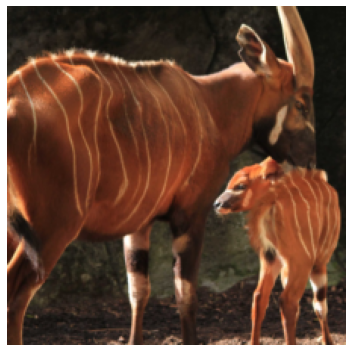

average alpha:0.475
alpha range:0.05


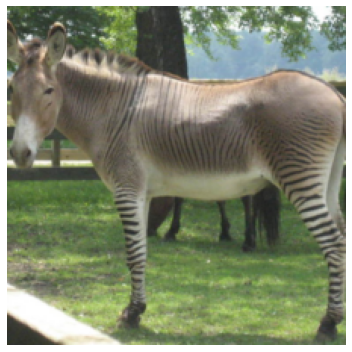

average alpha:0.350
alpha range:0.30


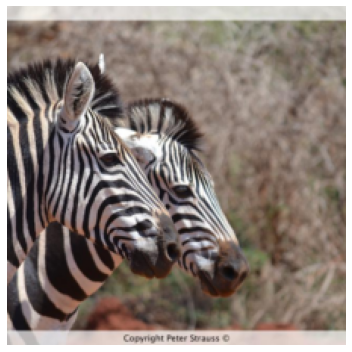

average alpha:0.550
alpha range:0.10


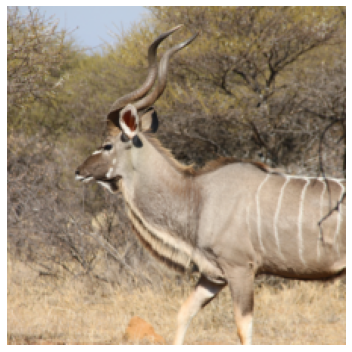

average alpha:0.600
alpha range:0.10


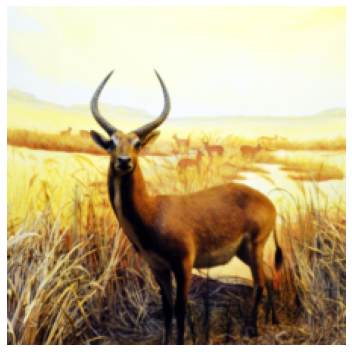

average alpha:0.900
alpha range:0.20


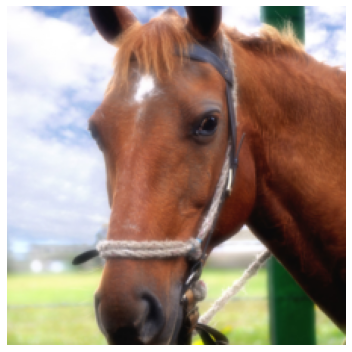

average alpha:0.225
alpha range:0.45


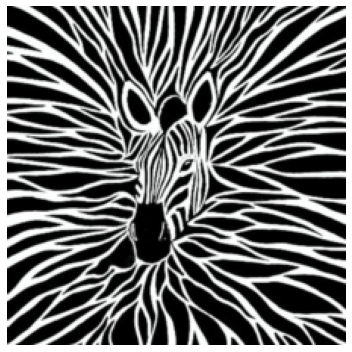

average alpha:0.200
alpha range:0.40


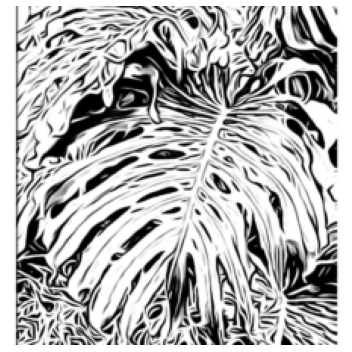

average alpha:0.825
alpha range:0.35


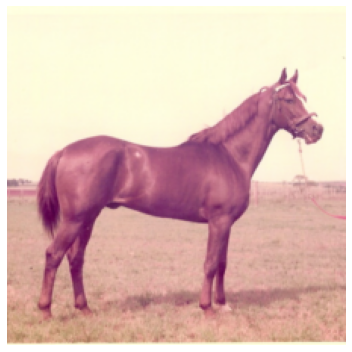

average alpha:0.075
alpha range:0.15


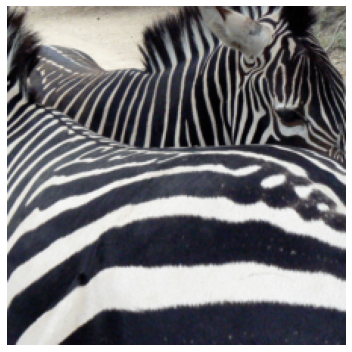

average alpha:0.850
alpha range:0.30


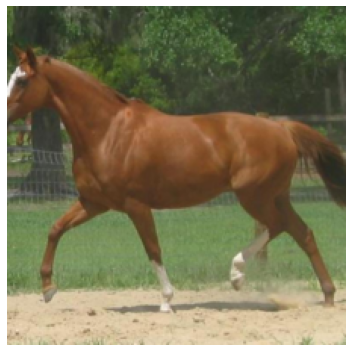

In [19]:
extract_image_list = []
for kk in range(len(alpha)):
    S = S_all[:,i,kk]
    S_idx = np.argsort(S)[::-1]
    for idx in range(3):  # extract top-3 images for each query
        extract_image_list.append(S_idx[idx])

extract_image_list = set(extract_image_list)
print(extract_image_list)
extract_image_list = list(extract_image_list)

for ii in range(len(extract_image_list)):
    image_idx = extract_image_list[ii]
    rank_list = []
    for kk in range(len(alpha)):
        S = S_all[:,i,kk]
        rank_list.append(np.sum(S>=S[image_idx]))
    best_rank = np.argmin(rank_list)
    top_3_range = [alpha[i] for i in range(len(alpha)) if rank_list[i] <= 3]
    # print(top_3_range)
    if len(top_3_range)>1:
        fig, ax = plt.subplots(figsize = (5,5))
        ax.label_outer()
        img_original = searching_image_set[image_idx][0]
        im = ax.imshow(np.transpose(img_original, (1, 2, 0)))
        plt.axis('off')
        ax.set_xticks([])
        ax.set_yticks([])
        fig.tight_layout()
        print("average alpha:" + "%.3f" % (0.5*(top_3_range[0]+top_3_range[-1])))
        print("alpha range:" + "%.2f" % ((top_3_range[-1]-top_3_range[0])))
        plt.show()